# Sử dụng phương pháp `Content-based filtering` (lọc dựa trên nội dung)

In [ ]:
!unzip '/content/drive/MyDrive/machinelearning/recommendation/tmdb_5000_movies.csv.zip' -d '/content/drive/MyDrive/machinelearning/recommendation'

Archive:  /content/drive/MyDrive/machinelearning/recommendation/tmdb_5000_movies.csv.zip
  inflating: /content/drive/MyDrive/machinelearning/recommendation/tmdb_5000_movies.csv  


Import các thư viện cần thiết:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import ast
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
%matplotlib inline

Load dữ liệu:

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/tmdb_5000_credits.csv')

In [ ]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [ ]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [ ]:
#trộn 2 tập dữ liệu theo tên phim

movies = movies.merge(credits, on='title')

In [ ]:
movies.shape

(4809, 23)

In [ ]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [ ]:
# Kiểm tra số hàng bị trùng:

movies.duplicated().sum()

0

## Lấy các trường dữ liệu cần:

1. genres
2. movie_id 
3. keywords
4. title
5. overview
6. cast
7. crew

In [ ]:
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

In [ ]:
# Kiểm tra các giá trị null:

movies.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [ ]:
# Xóa các hàng có giá trị null (vì chỉ có 3 hàng nên xóa đi không ảnh hưởng quá nhiều đến dữ liệu)

movies.dropna(inplace=True)

In [ ]:
movies.isnull().sum()

movie_id    0
title       0
overview    0
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [ ]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


## Tiền xử lý và làm sạch dữ liệu:

### Đầu tiên ta xử lý các trường dữ liệu có các bản ghi ở dạng JSON:

In [ ]:
# Cột genres

movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

##### Chuyển về dạng list string
['Action','Adventure','Fantasy','Science Fiction']

In [ ]:
# sử dụng thư viện ast để chuyển từ dạng JSON sang Dictionary
ast.literal_eval(movies.iloc[0].genres)

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [ ]:
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [ ]:
movies['genres'] = movies['genres'].apply(convert)

In [ ]:
movies.iloc[0].genres

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [ ]:
# cột keywords 

movies.iloc[0].keywords

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [ ]:
movies['keywords'] = movies['keywords'].apply(convert)

In [ ]:
# cột Cast 

movies['cast'][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [ ]:
# đối với cột "cast:, ta chỉ lấy ra 3 diễn viên đầu tiên

def convert3(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter+=1
        else:
            break
    return L 

In [ ]:
movies['cast'] = movies['cast'].apply(convert3)

In [ ]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [ ]:
# cột crew 

movies['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [ ]:
# Đối với cột "crew" ta chỉ lấy ra đạo diễn phim

def fetch_director(obj):
    L = []
    for i in ast.literal_eval(obj):
        if i['job']=='Director':
            L.append(i['name'])
            break
    return L
    

In [ ]:
movies['crew'] = movies['crew'].apply(fetch_director)

In [ ]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]


### Xử lý phần nội dung:

In [ ]:
movies['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [ ]:
# Split cột overview

movies['overview'] = movies['overview'].apply(lambda x:x.split())

In [ ]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


In [ ]:
# Xóa khoảng trắng 
# Sam Worthington --> SamWorthington

# Giảm thiểu sự trùng lặp dữ liệu, (ví dụ: "Kien" và "Kien " sẽ bị coi là khác nhau)

movies['genres']=movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['keywords']=movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])
movies['cast']=movies['cast'].apply(lambda x:[i.replace(" ","") for i in x])
movies['crew']=movies['crew'].apply(lambda x:[i.replace(" ","") for i in x])

In [ ]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton]


In [ ]:
# Tạo 1 cột tên là tags bao gồm các giá trị từ cột overview, genres, keywords, cast, crew

movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [ ]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],"[John, Carter, is, a, war-weary,, former, mili..."


In [ ]:
# Lúc này ta có một tập dữ liệu mới chỉ gồm 3 cột 'movie_id', 'title', 'tags'

new_df = movies[['movie_id','title','tags']]

In [ ]:
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


In [ ]:
# Nối các từ lại với nhau:

new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))

<ipython-input-28-4f7cfe687c2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))


In [ ]:
new_df['tags'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d SamWorthington ZoeSaldana SigourneyWeaver JamesCameron'

In [ ]:
# Viết thường tất cả các từ:

new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())

<ipython-input-30-2ab406140c4f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())


In [ ]:
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


In [ ]:
new_df['tags'][0]

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

Chuyển đổi văn bản thành một vectơ tần suất của mỗi từ xuất hiện trong toàn bộ văn bản.

In [ ]:
cv = CountVectorizer(max_features=5000, stop_words='english')    #loại bỏ các stopword

In [ ]:
vectors = cv.fit_transform(new_df['tags']).toarray()

In [ ]:
vectors[0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# sử dụng PorterStemmer chuyển từ về dạng gốc:

ps = PorterStemmer()

In [ ]:
#VD: dạng gốc của running là run
ps.stem('running')    

'run'

In [ ]:
def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [ ]:
new_df['tags'] = new_df['tags'].apply(stem)

<ipython-input-37-be18a4346d89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(stem)


In [ ]:
cv = CountVectorizer(max_features=5000, stop_words='english')   #giới hạn 5000 từ cho từng tags

In [ ]:
vectors = cv.fit_transform(new_df['tags']).toarray()

## Sử dụng cosine tính toán độ tương đồng giữa các vector(khoảng cách euclid):


In [ ]:
similarity = cosine_similarity(vectors)

In [ ]:
similarity 

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

In [ ]:
sorted(list(enumerate(similarity[1])), reverse=True, key=lambda x:x[1])[1:6]      #lấy 5 bộ phim có giá trị cosine tốt nhất với phim index = 1

[(12, 0.4140043409440133),
 (199, 0.27500954910846337),
 (17, 0.2533201985524494),
 (216, 0.20579830217101058),
 (3572, 0.20579830217101058)]

In [ ]:
# Hàm đề xuất phim
def recommend(movie, n = 5):
    movie_index = new_df[new_df['title'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1: n+1]
    
    titles_list = []
    for i in movies_list:
        titles_list.append(new_df.iloc[i[0]].title)
    return titles_list

In [ ]:
recommend('Batman Begins')

['The Dark Knight', 'Batman', 'Batman', 'The Dark Knight Rises', '10th & Wolf']

In [ ]:
recommend('Kung Fu Panda 2')

['Legend of a Rabbit',
 'Kung Fu Panda',
 'Kung Fu Panda 3',
 'The Adventures of Elmo in Grouchland',
 'Kickboxer: Vengeance']

Xuất kết quả tính toán thành các file .pkl để triển khai app:

In [ ]:
pickle.dump(new_df.to_dict(),open('/content/drive/MyDrive/machinelearning/recommendation/movie_dict.pkl','wb'))

In [ ]:
pickle.dump(similarity,open('/content/drive/MyDrive/machinelearning/recommendation/similarity.pkl','wb'))

## Đánh giá độ chính xác của model:

In [ ]:
import pandas as pd
# Load dữ liệu
movies_metadata = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/movies_metadata.csv')
ratings = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ratings_small.csv')

<ipython-input-3-8dcd7ec01cd0>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/movies_metadata.csv')


In [ ]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
movies_metadata.columns.tolist()

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [ ]:
ratings.columns.tolist()

['userId', 'id', 'rating', 'timestamp']

In [ ]:
movies_metadata['id'] = movies_metadata['id'].astype('str')
ratings['movieId'] = ratings['movieId'].astype('str')

# Gộp hai dataframe trên cột 'id' và 'movieId'
merged_data = pd.merge(movies_metadata, ratings, left_on='id', right_on='movieId')

In [ ]:
merged_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,userId,movieId,rating,timestamp
0,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,23,949,3.5,1148721092
1,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,102,949,4.0,956598942
2,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,232,949,2.0,955092697
3,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,242,949,5.0,956688825
4,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,263,949,3.0,1117846575


In [ ]:
# Create a pivot table of the ratings data
ratings_table = pd.pivot_table(merged_data, values='rating', index='userId', columns='title')

In [ ]:
ratings_table

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ratings_table.shape

(671, 2794)

In [ ]:
# loại bỏ các dòng chỉ chứa giá trị NaN:
ratings_table = ratings_table.dropna(how='all')

In [ ]:
ratings_table.shape

(671, 2794)

In [ ]:
ratings_table.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            662, 663, 664, 665, 666, 667, 668, 669, 670, 671],
           dtype='int64', name='userId', length=671)

In [ ]:
ratings_table_filtered = ratings_table.loc[ratings_table.count(axis=1) > 2]  #chỉ chọn các rating có số lượng lớn hơn 2

In [ ]:
ratings_table_filtered.shape

(671, 2794)

In [ ]:
ratings_table.loc[1]

title
!Women Art Revolution                  NaN
'Gator Bait                            NaN
'Twas the Night Before Christmas       NaN
...And God Created Woman               NaN
00 Schneider - Jagd auf Nihil Baxter   NaN
                                        ..
xXx                                    NaN
¡Three Amigos!                         NaN
À nos amours                           NaN
Ödipussi                               NaN
Şaban Oğlu Şaban                       NaN
Name: 1, Length: 2794, dtype: float64

In [ ]:
# Hàm lấy các bộ phim đã rate của một user:

def get_user_rated_movies(user_id, ratings_table):
    user_row = ratings_table.loc[user_id]
    user_rated_movies = user_row.dropna()
    return user_rated_movies.index.tolist()
get_user_rated_movies(362, ratings_table_filtered)   

['5 Card Stud',
 'A River Runs Through It',
 'A Woman, a Gun and a Noodle Shop',
 'American Pie 2',
 'Bad Boys II',
 'Beetlejuice',
 'Belle Époque',
 'Best Worst Movie',
 'Bridge to Terabithia',
 "Cheerleaders' Wild Weekend",
 'Confession of a Child of the Century',
 'Cool Hand Luke',
 'Cousin, Cousine',
 'Dawn of the Dead',
 "Don't Look Down",
 'Double Indemnity',
 'Downhill Racer',
 'Dreamgirls',
 'High Noon',
 'House of Dracula',
 'License to Wed',
 'Light of Day',
 'Local Color',
 'Millennium',
 'Million Dollar Baby',
 'Murder She Said',
 'My Name Is Bruce',
 'Salvatore Giuliano',
 'Say Anything...',
 'Shriek If You Know What I Did Last Friday the Thirteenth',
 'Sleepless in Seattle',
 'Solaris',
 'Stand by Me',
 'Terminator 3: Rise of the Machines',
 'The Conversation',
 'The Ewok Adventure',
 'The Holy Mountain',
 'The Last Samurai',
 'The Man with the Golden Arm',
 'The Mikado',
 'The Million Dollar Hotel',
 'The Out-of-Towners',
 'The Poseidon Adventure',
 'The Prisoner of Zend

In [ ]:
get_user_rated_movies(362, ratings_table_filtered)[0]

'5 Card Stud'

In [ ]:
# Danh sách phim trong tập dữ liệu train:

list_titles_small_data = new_df['title'].tolist()

In [ ]:
# Chọn ngẫu nhiên 100 người dùng từ bảng tổng hợp đã lọc
np.random.seed(42)
test_indices = np.random.choice(ratings_table_filtered.index, size=600, replace=False)

max_num_user = 100

# Đánh giá mô hình trên dữ liệu kiểm tra
correct_predictions = 0
total_predictions = 0
for user_id in test_indices:

    user_rated_movies = get_user_rated_movies(user_id, ratings_table_filtered)
    if len(user_rated_movies) == 0:
        continue

    movie = get_user_rated_movies(user_id, ratings_table_filtered)[0]

    if movie not in list_titles_small_data:
        continue

    top_recommendations = recommend(movie, 50)

    for movie_title in top_recommendations:
        if movie_title in get_user_rated_movies(user_id, ratings_table_filtered):
            correct_predictions += 1
            break
      
    total_predictions += 1
    if total_predictions == max_num_user:
        break

# Tính độ chính xác của mô hình
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)
print(correct_predictions)
print(total_predictions)

Accuracy: 0.28
28
100


In [6]:
def accuracy(n):
  # Chọn ngẫu nhiên 100 người dùng từ bảng tổng hợp đã lọc
  np.random.seed(4)
  test_indices = np.random.choice(ratings_table_filtered.index, size=600, replace=False)

  max_num_user = 100

  # Đánh giá mô hình trên dữ liệu kiểm tra
  correct_predictions = 0
  total_predictions = 0
  for user_id in test_indices:

      user_rated_movies = get_user_rated_movies(user_id, ratings_table_filtered)
      if len(user_rated_movies) == 0:
          continue

      movie = get_user_rated_movies(user_id, ratings_table_filtered)[0]

      if movie not in list_titles_small_data:
          continue

      top_recommendations = recommend(movie, n)

      for movie_title in top_recommendations:
          if movie_title in get_user_rated_movies(user_id, ratings_table_filtered):
              correct_predictions += 1
              break
        
      total_predictions += 1
      if total_predictions == max_num_user:
        break

  # Tính độ chính xác của mô hình
  accuracy = correct_predictions * 100 / total_predictions
  # print("Accuracy:", accuracy)
  # print(correct_predictions)
  # print(total_predictions)
  return round(accuracy, 3)

num_nei = []
acc = []
for i in range(5, 51, 5):
  num_nei.append(i)
  acc.append(accuracy(i))  
print(acc)
print(num_nei)

[4.6, 8.0, 9.1, 11.0, 13.0, 14.3, 15.1, 15.1, 15.7, 16.2]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


<ipython-input-11-890e739c16c2>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(dicts["Num_neighbor"], dicts["Accuracy"], 'o-', linestyle='--', label='Content-based with location')


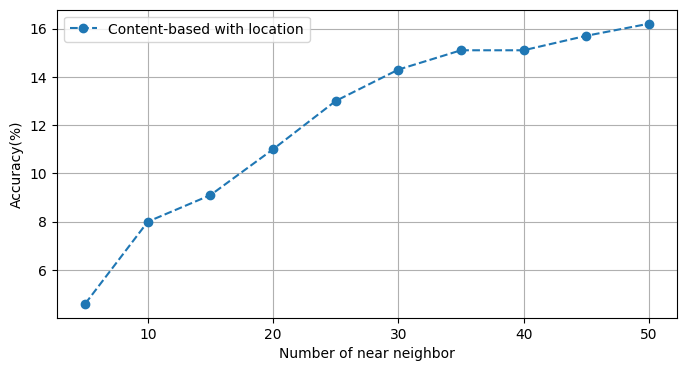

In [11]:
%matplotlib inline 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

dicts = {"Num_neighbor": num_nei,
         "Accuracy": acc}

fig, ax = plt.subplots(figsize=(8, 4))  # set the figure size to 8 inches wide and 6 inches tall

ax.plot(dicts["Num_neighbor"], dicts["Accuracy"], 'o-', linestyle='--', label='Content-based with location')
ax.set_xlabel('Number of near neighbor')
ax.set_ylabel('Accuracy(%)')
ax.legend()
ax.grid(True)
plt.show()

Trong đoạn code trên, ta sử dụng CountVectorizer để chuyển đổi các từ trong cột "tags" thành các vector và tính ma trận độ tương đồng cosine giữa các vector đó. Sau đó, ta sử dụng cosine similarity để tìm các bộ phim có độ tương đồng cao với bộ phim được chọn.

Cụ thể, thuật toán làm như sau:

Sử dụng CountVectorizer để tạo ra một ma trận với mỗi hàng là một bộ phim, mỗi cột là một từ xuất hiện trong các tag của các bộ phim. Số cột được giới hạn bằng max_features, và ta sẽ loại bỏ các stop words trong tiếng Anh thông qua tham số stop_words.

Sử dụng cosine_similarity của scikit-learn để tính toán ma trận độ tương đồng cosine giữa các bộ phim dựa trên ma trận vector từ CountVectorizer.

Để đưa ra các đề xuất bộ phim, ta sẽ chọn một bộ phim đầu vào và tìm các bộ phim có độ tương đồng cosine cao nhất với nó. Ta sắp xếp các bộ phim đó theo thứ tự giảm dần và trả về n bộ phim đầu tiên.

Công thức tính toán cosine similarity giữa hai vector x và y được cho bởi công thức:

$cosine_similarity(x,y) = \frac{x \cdot y}{||x|| ||y||}$

Trong đó, x và y là hai vector cần so sánh, $\cdot$ là phép nhân vector, và $||\cdot||$ là độ dài Euclid của vector đó. Kết quả của cosine similarity là một số thực trong khoảng [-1,1], cho biết mức độ tương đồng giữa hai vector. Khi kết quả gần với 1, hai vector tương đồng cao và gần với -1 thì hai vector tương đối khác biệt.